In [1]:
from typing import Annotated,TypedDict
from typing_extensions import TypedDict,Annotated
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages


### Annotated 
Annotated allows you to attach metadata to a type without changing its runtime behavior.

Annotated[BaseType, metadata]

BaseType → the actual Python type (e.g., list, int, str)
metadata → extra information for tools/IDEs/frameworks (like LangGraph, Pydantic, or validators)

At runtime, Python still sees only BaseType

The metadata is ignored by Python but can be read by tools

In [2]:
class State(TypedDict):
    messages:Annotated[list,add_messages] #add_messages is a reducer which appends messages to the list instead of overwriting it.add_messages can be used by LangGraph nodes internally, e.g., to append or validate messages

### `Annotated[list, add_messages]` vs `Annotated[list[BaseMessage], add_messages]`

Both forms define a `messages` field in LangGraph state and use `add_messages` as metadata to tell LangGraph how to merge message lists.  
The key difference is **type safety of the list contents**.

- `Annotated[list, add_messages]`  
  - `messages` is a generic list  
  - Can contain **any type** (strings, dicts, numbers, etc.)  
  - No validation of what goes inside the list  
  - Higher risk of runtime errors when passing messages to an LLM  

- `Annotated[list[BaseMessage], add_messages]`  
  - `messages` is a list of `BaseMessage` objects only  
  - Ensures each item is a valid chat message (e.g., `HumanMessage`, `AIMessage`)  
  - IDE and type checkers warn if invalid items are added  
  - Safer and recommended for LLM-based agents  

**Important:**  
`Annotated` does not change runtime behavior. It only attaches metadata (`add_messages`) and type information for tools like LangGraph, IDEs, and type checkers.

**Recommendation:**  
Use `Annotated[list[BaseMessage], add_messages]` for reliable, production-ready agent state definitions.


In [3]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')



In [4]:
from langchain_openai import ChatOpenAI

llm =ChatOpenAI(model ='gpt-4o-mini')
llm.invoke('Hello my name is Arshad')

AIMessage(content='Hello, Arshad! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 14, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688', 'id': 'chatcmpl-CujbuzlyCVPCjXtYHF8wNZVmaCmDh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b8f6b-422b-7fd2-999b-6c171f652c3f-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 14, 'output_tokens': 13, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
from langchain_groq import ChatGroq
llm_chatgroq = ChatGroq(model='llama-3.1-8b-instant')
llm_chatgroq.invoke('hi my name is arshad')

AIMessage(content="Hello Arshad, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 42, 'total_tokens': 70, 'completion_time': 0.026647584, 'completion_tokens_details': None, 'prompt_time': 0.002551736, 'prompt_tokens_details': None, 'queue_time': 0.088444991, 'total_time': 0.02919932}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b8f6b-49da-7263-a95e-a29f4fcb1aab-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 42, 'output_tokens': 28, 'total_tokens': 70})

Step 1 : Create Nodes

In [7]:
def superbot(state:State):
    return {"messages":[llm_chatgroq.invoke(state['messages'])]}


Step 2 : Create StateGraph ,Nodes ,Edges and compile it

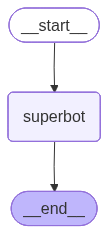

In [8]:
graph = StateGraph(State)

graph.add_node('superbot',superbot)

graph.add_edge(START,'superbot')
graph.add_edge('superbot',END)

graph_builder =graph.compile()

from IPython.display import display,Image

display(Image(graph_builder.get_graph().draw_mermaid_png()))

Step 3 : Invocation 

In [9]:
graph_builder.invoke({"messages":"Hi How are you and where are u located?"})

{'messages': [HumanMessage(content='Hi How are you and where are u located?', additional_kwargs={}, response_metadata={}, id='e3ce58df-4081-46ce-ac34-03dda8e0e8b6'),
  AIMessage(content="I'm doing well, thank you for asking. As for my location, I don't have a physical presence. I'm a cloud-based language model, which means I exist only in the digital realm and can be accessed from anywhere with an internet connection. I'm a virtual assistant designed to provide information and assist with tasks, so I don't have a specific location like a city or country. How about you? Where are you located?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 45, 'total_tokens': 134, 'completion_time': 0.195458569, 'completion_tokens_details': None, 'prompt_time': 0.058026406, 'prompt_tokens_details': None, 'queue_time': 0.091591076, 'total_time': 0.253484975}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': '

Using Gradio Chat Interface just for clean side 

In [ ]:
import gradio as gr

from langchain_core.messages import HumanMessage

def chat(user_input,history):
    result =graph_builder.invoke({"messages":[HumanMessage(content=user_input)]})
    print(result)
    return result['messages'][-1].content

gr.ChatInterface(chat,type="messages").launch()


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hey man', additional_kwargs={}, response_metadata={}, id='c7820b62-1419-49b7-8246-335ea72ce35a'), AIMessage(content="What's up? Is there something I can help you with or do you just want to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 37, 'total_tokens': 58, 'completion_time': 0.031577238, 'completion_tokens_details': None, 'prompt_time': 0.024295369, 'prompt_tokens_details': None, 'queue_time': 0.098178108, 'total_time': 0.055872607}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019b97fc-e01a-7b61-804e-565dac64f2ec-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 37, 'output_tokens': 21, 'total_tokens': 58})]}
{'messages': [HumanMessage(content='so what is the time now', additional_kwargs={}, response_metadata={}, id='5e420